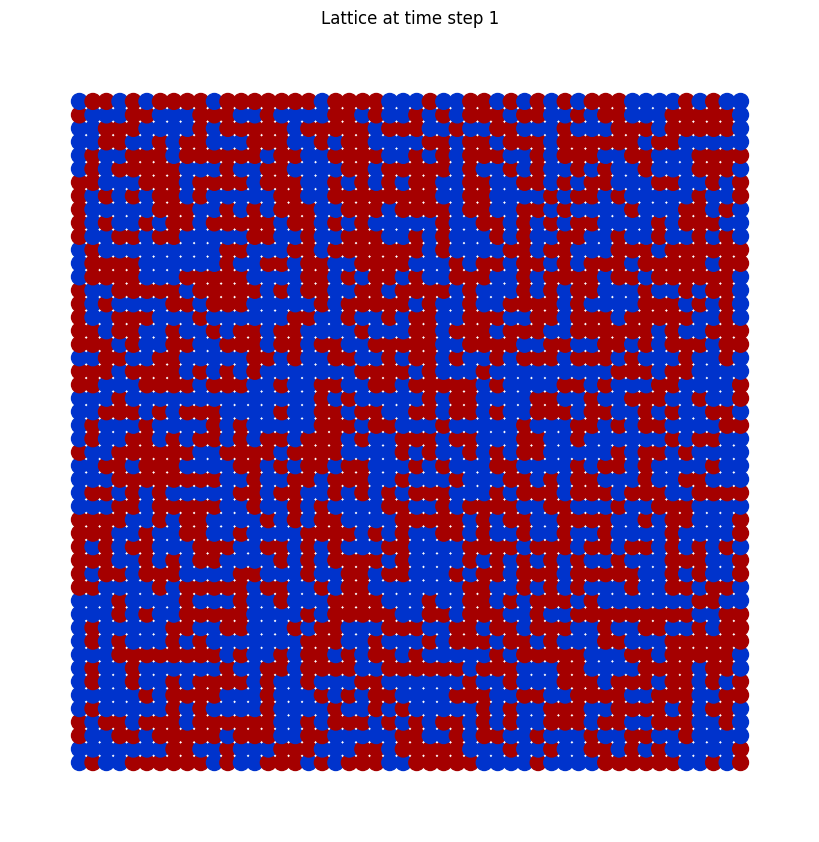

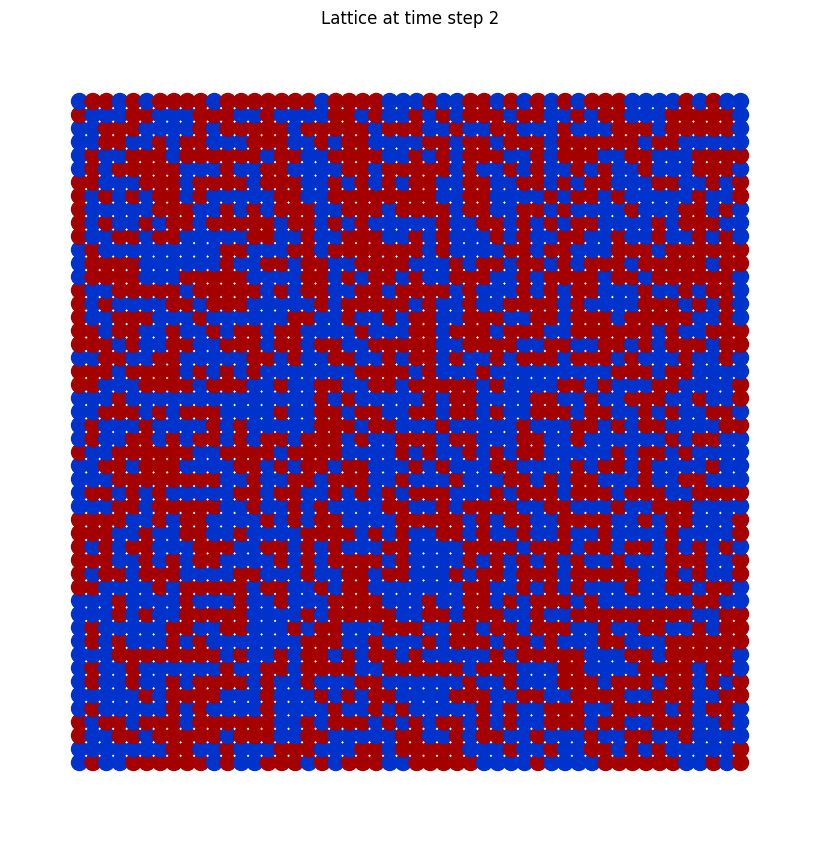

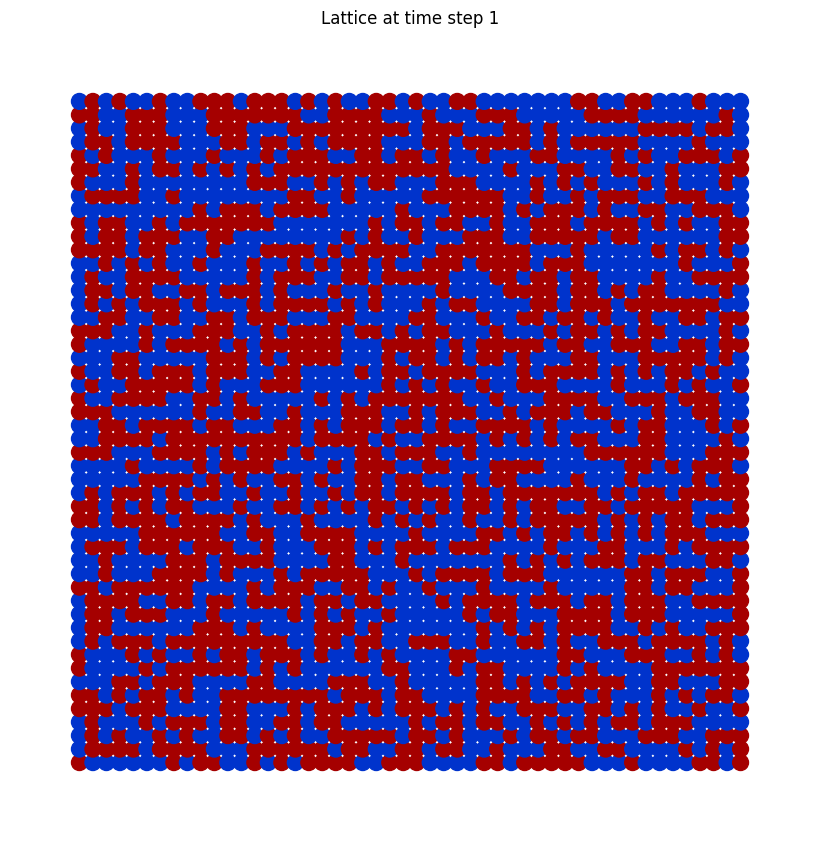

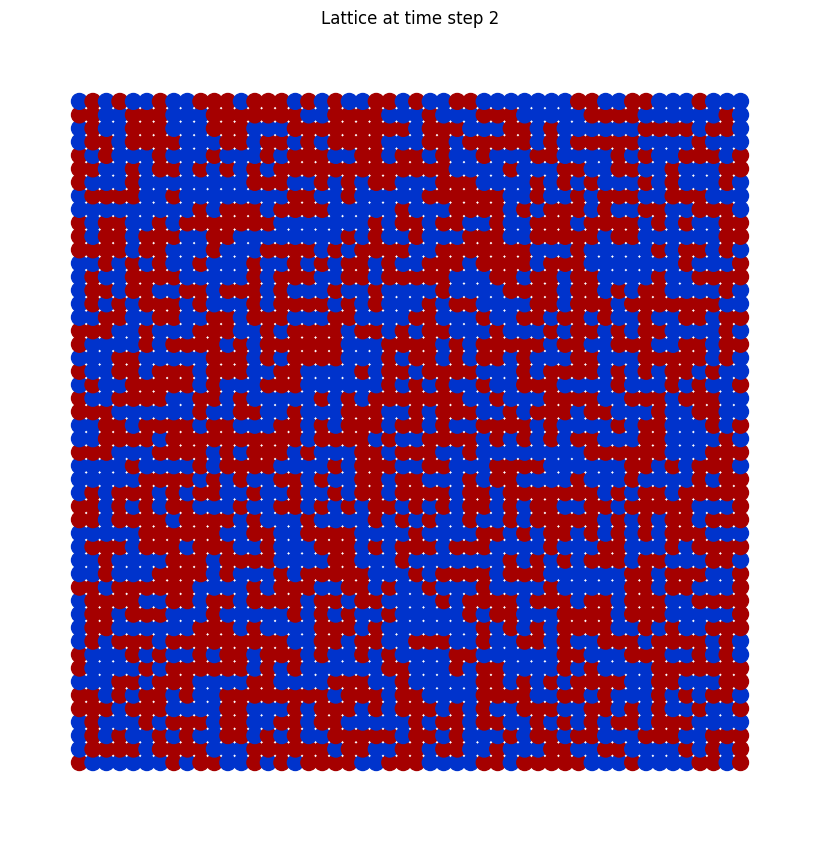

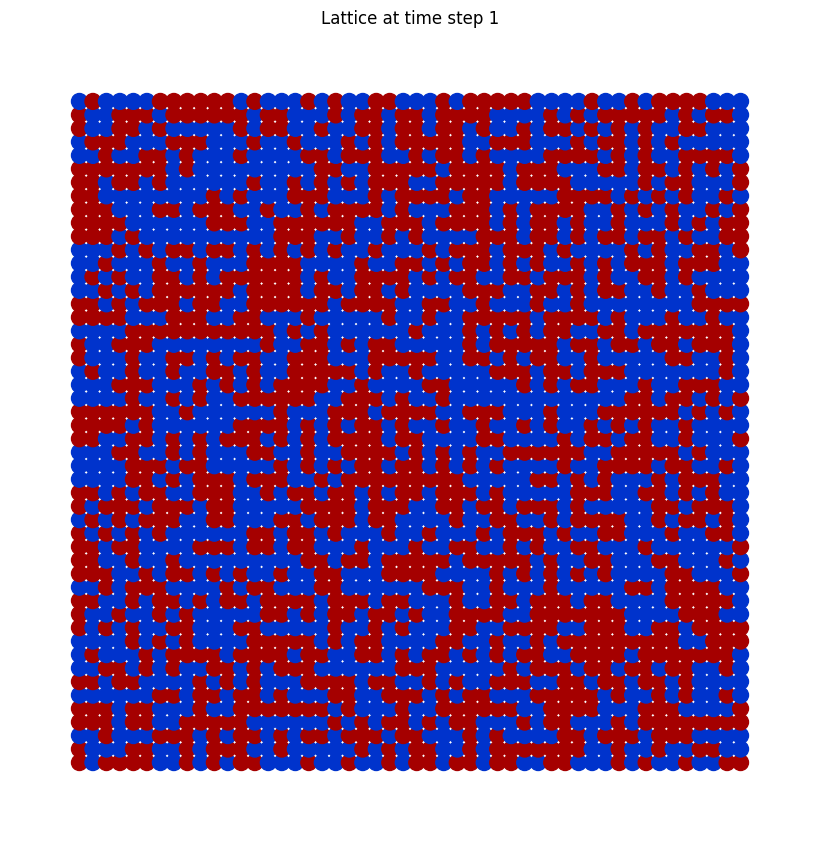

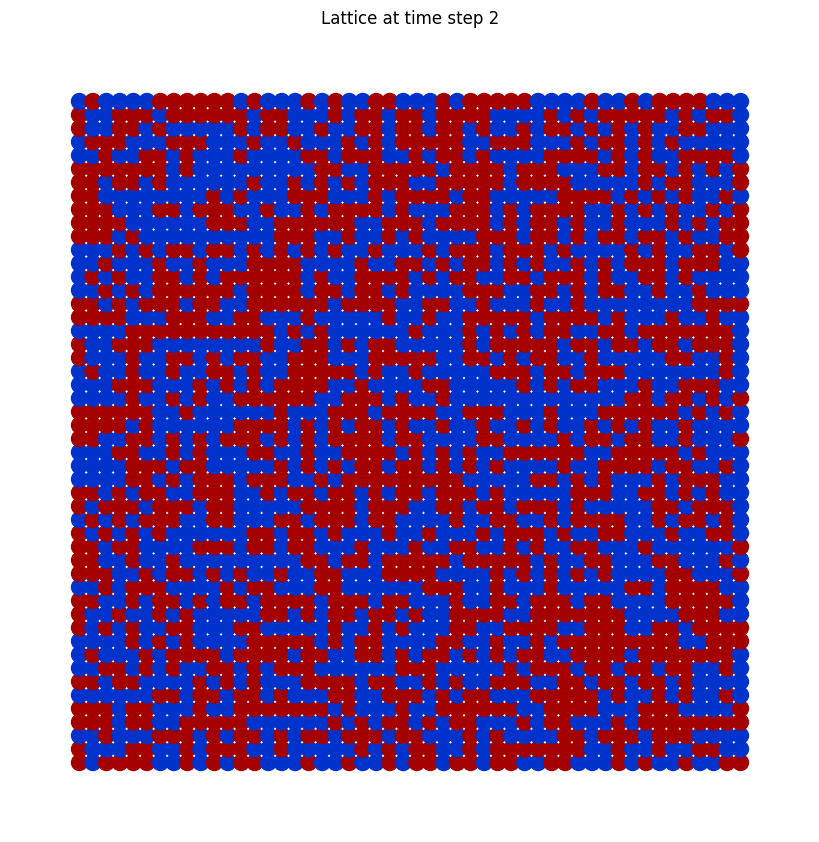

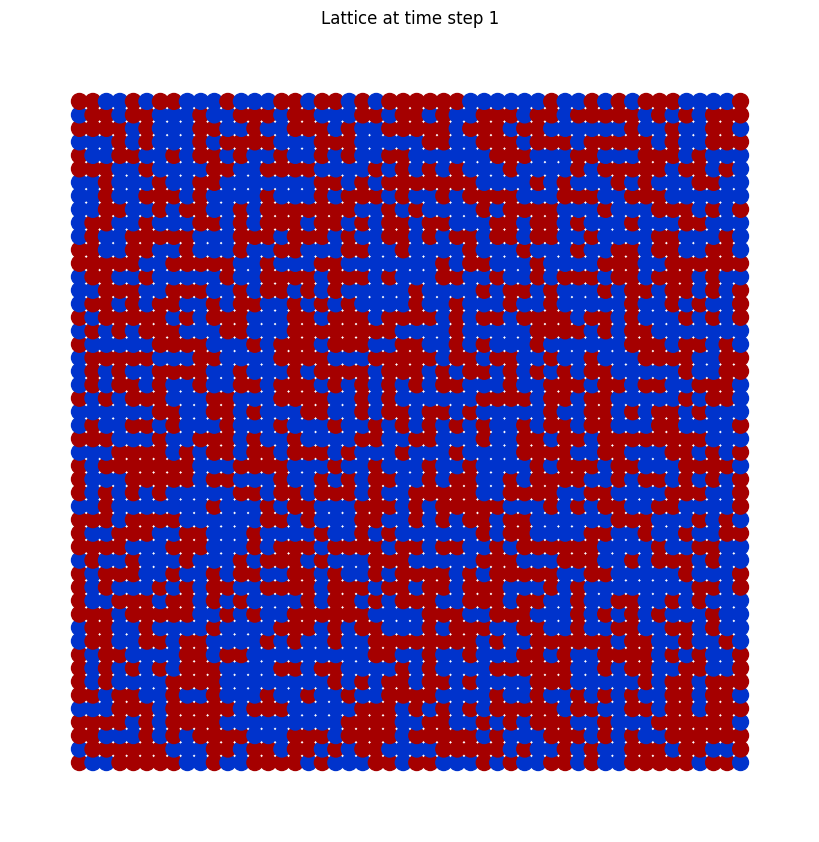

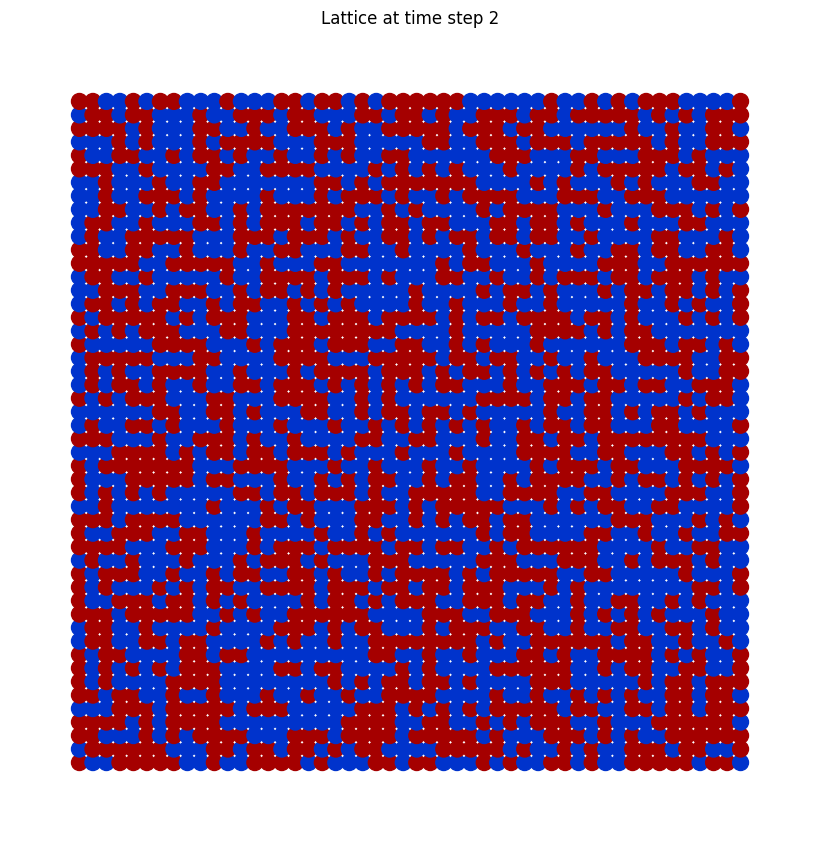

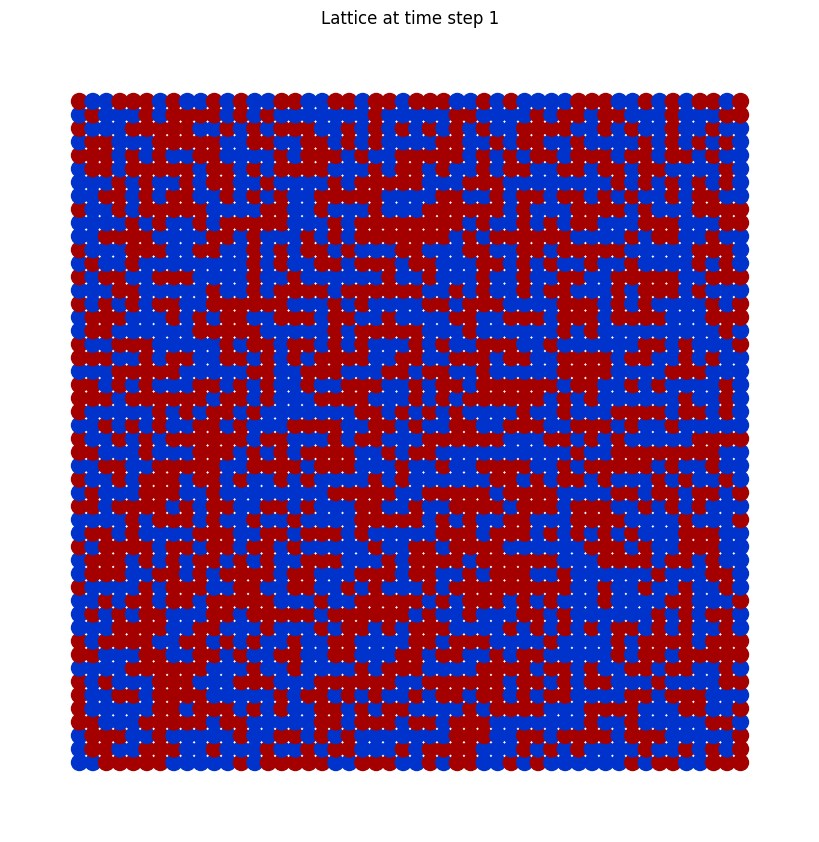

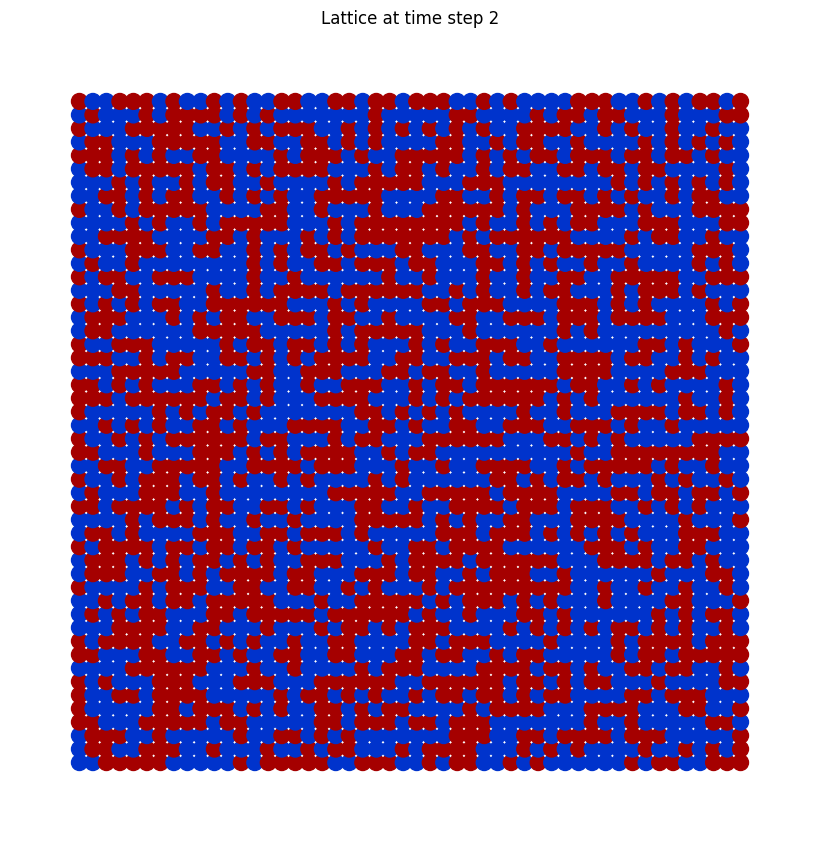

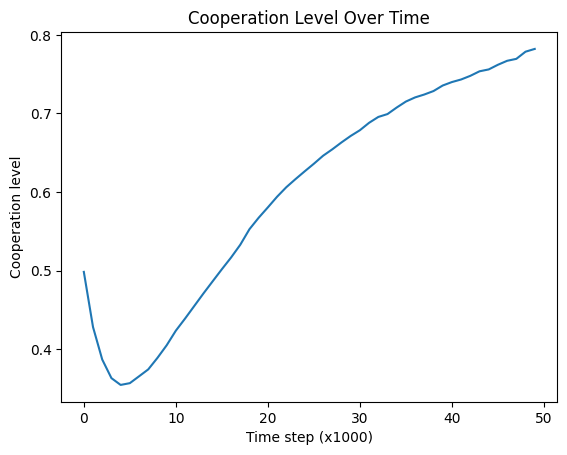

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
import math
#2 homogenus
# 2 hetero avr-avr poor
#  2 hetero avr-avr rich
# 2 rich - poor (without average)
#  500k-1mln

# Adjust grid size to 30x30
GRID_SIZE = 50
NUM_AGENTS = GRID_SIZE * GRID_SIZE  # Total number of agents
RICH_SITE_PROB = 0.0  # Fraction of rich sites (adjust as needed)
AVERAGE_SITE_PROB = 0.0  # Fraction of average sites (you can adjust as needed)
INITIAL_COOPERATION_PROB = 0.50

c = 10  # Resource contrast (c) between rich and poor sites

DEFECTOR_COST = 1  # A small cost or penalty for choosing defection

COOPERATION_CLUSTER_BONUS = 0.7
PUBLIC_GOOD_BONUS = 2  # r, public good bonus
b = 1.1 # Temptation to defect
TEMPTATION_LEVEL = b - 1
m = 10  # Parameter for strategy change

# Payoff matrix parameters
RICH_RESOURCE = 1 + c
AVERAGE_RESOURCE = math.sqrt(11)   # Average site resource, value sqrt(11) because means that its contrast is the same for the rich and poor resource
POOR_RESOURCE = 1


c_a = (AVERAGE_RESOURCE - POOR_RESOURCE)/POOR_RESOURCE  # Resource contrast (c) between average and poor sites +/- 2.31



# Create a 2D grid of agents (lattice)
def create_lattice():
    G = nx.grid_2d_graph(GRID_SIZE, GRID_SIZE, periodic=True)  # 2D grid with periodic boundary
    assign_resources(G)
    initialize_strategies(G, INITIAL_COOPERATION_PROB)
    return G

# Assign resources to rich, poor, and average sites
def assign_resources(G):
    for node in G.nodes():
        rand = random.random()
        if rand < RICH_SITE_PROB:
            G.nodes[node]['resource'] = RICH_RESOURCE
            G.nodes[node]['site_type'] = 'rich'
        elif rand < RICH_SITE_PROB + AVERAGE_SITE_PROB:
            G.nodes[node]['resource'] = AVERAGE_RESOURCE
            G.nodes[node]['site_type'] = 'average'
        else:
            G.nodes[node]['resource'] = POOR_RESOURCE
            G.nodes[node]['site_type'] = 'poor'

# Initialize strategies for agents (either cooperate 'C' or defect 'D')
def initialize_strategies(G, cooperation_prob):
    for node in G.nodes():
        G.nodes[node]['strategy'] = 'C' if random.random() < cooperation_prob else 'D'

# Play the game for a selected node and its neighbors
def play_game(G, selected_node):
    payoffs = {}
    nodes_to_update = [selected_node] + list(G.neighbors(selected_node))
    for node in nodes_to_update:
        strategy = G.nodes[node]['strategy']
        site = G.nodes[node]['site_type']
        payoff = 0
        neighbors = list(G.neighbors(node))

        for neighbor in neighbors:
            neighbor_strategy = G.nodes[neighbor]['strategy']
            neighbor_site = G.nodes[neighbor]['site_type']

            # Payoff matrix from the paper (rich, average, and poor site interactions)
            payoff += calculate_payoff(strategy, site, neighbor_strategy, neighbor_site)

        payoffs[node] = payoff
    return payoffs

def calculate_payoff(strategy, site, neighbor_strategy, neighbor_site):
    payoff = 0
    b_local = b
    c_local = c
    c_a_local = c_a
    

    # Simplified payoff calculation based on the site type and strategies
    # rich-rich interactions
    if site == 'rich' and neighbor_site == 'rich':
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = 2 * c_local + 1
            else:
                payoff = c_local
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local * c_local + b_local + c_local
            else:
                payoff = b_local * c_local + b_local - 1
    # rich-poor interactions
    elif site == 'rich' and neighbor_site == 'poor':
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = c_local + 1
            else:
                payoff = c_local
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local * c_local + b_local
            else:
                payoff = b_local * c_local + b_local - 1
    # poor-rich interactions
    elif site == 'poor' and neighbor_site == 'rich':
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = c_local + 1
            else:
                payoff = 0
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local + c_local
            else:
                payoff = b_local - 1
    # poor-poor interactions
    elif site == 'poor' and neighbor_site == 'poor':  # site == 'poor'
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = 1
            else:
                payoff = 0
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local
            else:
                payoff = b_local - 1
    
    # AVERAGE INTERACTIONS
    # average-rich interactions mimics poor-rich
    elif site == 'average' and neighbor_site == 'rich':
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = c_a_local + 1
            else:
                payoff = 0
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local + c_a_local
            else:
                payoff = b_local - 1
    # rich-average interactions
    elif site == 'rich' and neighbor_site == 'average':
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = c_a_local + 1
            else:
                payoff = c_a_local
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local * c_a_local + b_local
            else:
                payoff = b_local * c_a_local + b_local - 1
    # average-poor interactions
    elif site == 'average' and neighbor_site == 'poor':
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = c_a_local + 1
            else:
                payoff = c_a_local
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local * c_a_local + b_local
            else:
                payoff = b_local * c_a_local + b_local - 1
    # poor-average interaction
    elif site == 'poor' and neighbor_site == 'average':
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = c_a_local + 1
            else:
                payoff = 0
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local + c_a_local
            else:
                payoff = b_local - 1
    #average-average mimic poor-poor and rich-rich
    else:
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff =  AVERAGE_RESOURCE                       # AVERAGE_RESOURCE    # 2 * c_a_local + 1
            else:
                payoff = 0                              # 0 # c_a_local 
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local                # b_local        #b_local * c_a_local + b_local + c_a_local
            else:
                payoff = b_local -1                                # b_local -1    #b_local * c_a_local + b_local - 1
    

    return payoff

# Update strategy for only the selected node
def update_strategy(G, payoffs, selected_node):
    mutation_prob = 0.00  # Small chance of strategy mutation
    m = 10  # Exponent

    node = selected_node
    if random.random() < mutation_prob:
        # Mutate strategy
        current_strategy = G.nodes[node]['strategy']
        new_strategy = 'C' if current_strategy == 'D' else 'D'
    else:
        neighbors = list(G.neighbors(node))
        neighbors.append(node)  # Include self in possible models
        total_payoff = 0.0
        payoff_list = []

        # Compute total payoff raised to exponent m
        for neighbor in neighbors:
            payoff = payoffs[neighbor]
            payoff_m = max(payoff, 0) ** m  # Ensure non-negative before raising to m
            payoff_list.append((neighbor, payoff_m))
            total_payoff += payoff_m

        if total_payoff == 0:
            # All payoffs are zero or negative; choose randomly
            selected_neighbor = random.choice(neighbors)
        else:
            # Select a neighbor proportional to payoff^m
            probabilities = [payoff_m / total_payoff for _, payoff_m in payoff_list]
            selected_neighbor = random.choices(
                [neighbor for neighbor, _ in payoff_list],
                weights=probabilities,
                k=1
            )[0]

        new_strategy = G.nodes[selected_neighbor]['strategy']

    # Apply the new strategy to the node
    G.nodes[node]['strategy'] = new_strategy

import matplotlib.pyplot as plt
import networkx as nx

def plot_lattice(G, timestep):
    """
    Plot a lattice where node color is determined by strategy and site_type.
    Cooperators (C) are blue or light blue based on site type.
    Defectors (D) are red or light red based on site type.
    """
    node_colors = []
    
    for node in G.nodes():
        strategy = G.nodes[node].get('strategy')  # 'C' or 'D'
        site_type = G.nodes[node].get('site_type')  # 'rich' or 'poor'
        
        if strategy == 'C':
            if site_type == 'rich':
                node_colors.append('#99CCFF')  # Cooperators on rich sites - Ligh blue
            elif site_type == 'average':
                node_colors.append('#3399FF')  # Cooperators on average sites - Medium Blue
            else:
                node_colors.append('#0033CC')       # Cooperators on poor sites - dark blue
        elif strategy == 'D':
            if site_type == 'rich':
                node_colors.append('#FF9999') # Defectors on rich sites - light red
            elif site_type == 'average':
                node_colors.append('#FF3333')  # defectors on average sites - medium red
            else:
                node_colors.append('#A50000')        # Defectors on poor sites - dark red
        else:
            node_colors.append('grey')           # Default in case of missing strategy
    
    # Draw the grid with proper node colors
    pos = dict((n, n) for n in G.nodes())  # Use grid positions
    plt.figure(figsize=(8, 8))
    
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=130, edge_color='black', width=0.05)
    
    plt.title(f"Lattice at time step {timestep}")
    plt.show()


# Simulation loop
def simulate():
    G = create_lattice()
    cooperation_levels = []
    num_time_steps = 500000  # Adjust as needed

    for t in range(num_time_steps):  # Simulate for specified time steps
        selected_node = random.choice(list(G.nodes()))
        
        # Node plays the game with neighbors
        payoffs = play_game(G, selected_node)
        
        # Update strategy for only the selected node
        update_strategy(G, payoffs, selected_node)
        
        # Record cooperation level
        if t % 1000 == 0:  # Adjust frequency of recording as needed
            num_cooperators = sum(1 for node in G.nodes() if G.nodes[node]['strategy'] == 'C')
            cooperation_level = num_cooperators / NUM_AGENTS
            cooperation_levels.append(cooperation_level)
        
        # Visualization (optional)
        if t == 1:
            plot_lattice(G, t+1)
        if (t % 50000 == 0):
            plot_lattice(G, t+1)
    
    return cooperation_levels, G



def simulateAverage():
    average_cooperation = []
    for i in range(5):
        cooperation_levels, G = simulate()
        average_cooperation.append(cooperation_levels)
    average_cooperation = np.mean(average_cooperation, axis=0)

    plt.plot(average_cooperation)
    plt.xlabel("Time step (x1000)")
    plt.ylabel("Cooperation level")
    plt.title("Cooperation Level Over Time")
    plt.show()
# Run the simulation and plot the final state
# cooperation_levels, G = simulate()

# Plot the cooperation level over time
# plt.plot(cooperation_levels)
# plt.xlabel("Time step (x1000)")
# plt.ylabel("Cooperation level")
# plt.title("Cooperation Level Over Time")
# plt.show()
simulateAverage()